# Classical Inference

G. Richards 
(2016, 2018, 2020, 2022)
with material from Ivezic [Sections 4.0, 4.1, 4.2, 4.3, 4.5, 5.0, 5.1, 5.2], Bevington, and Leighly.  With updates to my own class from [Stephen Taylor's class at Vanderbilt](https://github.com/VanderbiltAstronomy/astr_8070_s22); note that we'll cover in just 2 lectures, what they cover in 7, so see those notebooks if you'd like more detail.

## Contents
* [Statistical Inference](#one)
* [Maximum Likelihood Estimation](#two)
* [MLE Applied To A Homoscedastic Gaussian](#three)
* [Quantifying Estimate Uncertainty](#four)
* [Confidence Intervals](#five)
* [MLE Applied To A Heteroscedastic Gaussian](#six)
* [Aside: Cost Functions](#seven)
* [Goodness of Fit](#eight)
* [Example: Polynomial Fitting](#nine)
* [Model Comparison](#ten)
* [Hypothesis Testing](#eleven)

## Statistical Inference <a class="anchor" id="one"></a>

Statistical **inference** is about drawing conclusions from data, specifically determining the properties of a population by data sampling.  

Three examples of inference are:
* What is the best estimate for a model parameter?
* How confident we are about our result?
* Are the data consistent with a particular model/hypothesis?

### Some Terminology

* We typically study the properties of some ***population*** by measuring ***samples*** from that population. 
* A ***statistic*** is any function of the sample. For example, the sample mean is a statistic. But also, "the value of the first measurement" is also a statistic.
* To conclude something about the population from the sample, we develop ***estimators***. An estimator is a statistic based on observed data.
* There are ***point*** and ***interval estimators***. Point estimators yield single-valued results (example: the position of an object), while with an interval estimator, the result would be a range of plausible values (example: confidence interval for the position of an object).
* Measurements have **uncertainties** (not errors) and we need to account for these (sometimes they are unknown).

### Frequentist vs. Bayesian Inference

There are two major statistical paradigms that address the statistical inference questions: 
- the **classical**, or **frequentist** paradigm,
- the **Bayesian** paradigm.

While most of statistics and machine learning is based on the classical paradigm, Bayesian techniques are being embraced by the statistical and scientific communities at an ever-increasing pace...especially in astrophysics.

For more insight see [Jake VanderPlas's blog "Frequentism and Bayesianism: A Practical Introduction](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/).

#### Key differences
- **Definition of probabilities**:
    - In ***frequentist inference***, probabilities describe the ***relative frequency of events*** over repeated experimental trials. 
    - In ***Bayesian infernece***, probabilities instead quantify our ***subjective belief about experimental outcomes, model parameters, or even models themselves***. 
    
In short, classical (frequentist) statistics is concerned with the frequency with which $A$  happens in identical repeats of an experiment, i.e., $p(A)$. Bayesian statistics is concerned instead with $p(A|B)$, which is how plausible it is for $A$ to happen given the knowledge that $B$ has happened (or is true).     
    
- **Quantifying uncertainty**:
    - In ***frequentist inference*** we have ***confidence levels*** that describe the distribution of the measured parameter from the data around the true value.
    - In ***Bayesian inference*** we have ***credible regions*** derived from posterior probabilitiy distributions (we'll meet these later). These encode our "***belief spread***" in model parameters. 

My colleague, Karen Leighly, dug up the following article, which might help one to understand the differences in these approaches in a relatively simply way.  The first 4 sections are what is relevant here.
[Efron 1978](http://www.jstor.org/stable/2321163?seq=1#page_scan_tab_contents)

I'll briefly (and perhaps too cavalierly) summarize it.

Let's say that you get the results of an IQ test.  Any given test result might not give you your "real" IQ.  But it gives us a way to *estimate* it (and the possible range of values).  

For a frequentist, the best estimator is just the average of many test results.  So, if you took 5 IQ tests and got a sample mean of 160, then that would be the estimator of your true IQ.

On the other hand, a Bayesian would say: "but wait, I know that IQ tests are normed to 100 with a standard deviation of 15 points".  So they will use that as "prior" information, which is important here since 160 is a 4$\sigma$ outlier. 

There's nothing mysterious about priors. It simply encodes any previous knowledge or information we have about our experiment.

In [ ]:
# Execute this cell
%matplotlib inline
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt

Complete and execute the following cell. It will show the simple average of IQ tests, the prior distribution one would use in a Bayesian analysis, and the final Bayesian posterior "belief" distribution.

In [ ]:
#------------------------------------------------------------
# Define the distributions to be plotted
sigma_values = [___, 6.7, 1] #complete with the prior width of IQ distribution
linestyles = ['--', '-', ':']
mu_values = [____, 148, 160] #complete with the prior mean of IQ distribution
labeltext = ['prior dist.', 'posterior dist.', 'observed mean']
xplot = np.linspace(50, 200, 1000)

#------------------------------------------------------------
# plot the distributions
fig, ax = plt.subplots(figsize=(10, 7.5))

for sigma, ls, mu, lab in zip(sigma_values, linestyles, mu_values, labeltext):
    # create a gaussian / normal distribution
    dist = norm(mu, sigma)

    if (sigma>1):
        plt.plot(xplot, dist.pdf(xplot), ls=ls, c='black',label=r'%s $\mu=%i,\ \sigma=%.1f$' % (lab, mu, sigma))
    else:
        plt.plot([159.9,160.1],[0,0.8], ls=ls, color='k', label=r'%s $\mu=%i$' % (lab, mu))
        
plt.xlim(50, 200)
plt.ylim(0, 0.1)
plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu,\sigma)$')
plt.title('Gaussian Distribution')
plt.legend()

The end result (skipping over the detailed math) is that the Bayesian estimate of the IQ is not 160, but rather 148, or more specifically that $p(141.3\le \mu \le 154.7 \, | \, \overline{x}=160) = 0.683$.

That's actually fine, where the controvery comes in is when the Bayesian wants to do the same things but doesn't actually know the prior distribution, or when the parameter is fixed but we are trying to experimentally verify it (e.g., the speed of light).

## Maximum Likelihood Estimation (MLE), Ivezic 4.2  <a class="anchor" id="two"></a>

Let's not worry about classical vs. Bayesian right now and talk about maximum likelihood estimation (Ivezic, 4.2), which is relevant to both.

Maximum likelihood estimation follows this blueprint:

1. **Hypothesis**: Formulate a model, a *hypothesis*, about how the data are generated. For example, the data are a measurement of some quantity with Gaussian random uncertainties (i.e., each measurement is equal to the true value, plus a deviation randomly drawn from the normal distribution). Models are typically described using a set of model parameters $\boldsymbol{\theta}$, and written as $\boldsymbol{M}(\boldsymbol{\theta})$.


2. **Maximum Likelihood Estimation**: Search for the "best" model parameters $\boldsymbol{\theta}$ which maximize the ***likelihood*** $L(\boldsymbol{\theta}) \equiv p(D|M)$. This search yields the MLE *point estimates*, $\boldsymbol{\theta^0}$.


3. **Quantifying Estimate Uncertainty**: Determine the confidence region for model parameters, $\boldsymbol{\theta^0}$. Such a confidence estimate can be obtained analytically (possibly with some approximations), but can also be done numerically for arbitrary models using general frequentist techniques, such as bootstrap, jackknife, and cross-validation (we'll come to these later).


4. **Hypothesis Testing**: Perform hypothesis tests as needed to make other conclusions about models and point estimates. Possibly GOTO #1.

### Example: Measuring the Position of a Quasar

Let's assume we wish to estimate the position, $x$, of a quasar from a series of individual astrometric measurements.

1. We adopt a model where the observed quasar does not move, and has individual measurement uncertainties 
2. We derive the expression for the likelihood of there being a quasar at position $x_0$ that gives rise to our individual measurements. We find the value of $\hat x_0$ for which our observations are maximally likely.
3. We determine the uncertainties (confidence intervals) on our measurement.
4. We test whether what we've observed is consistent with our adopted model. For example, is it possible that the quasar was really a misidentified star with measurable proper motion?

Note: in the text to come, I will use $\mu$ instead of $x_0$ to denote the true position of the quasar. This is to avoid potential confusion with the first (or zeroth) measurement of $x$.

If we know the distribution from which our data were drawn, then we can compute the **probability** of our data.  

For example if you know that your data are drawn from a model with a Gaussian distribution, then we've already seen that the probablity of getting a specific value of $x$ is given by
$$p(x|\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right).$$

In [ ]:
# Execute this cell
#------------------------------------------------------------
# plot the distributions
fig, ax = plt.subplots(figsize=(10, 7.5))
dist = norm(5, 1)
x = np.linspace(0, 10, 1000)
plt.plot(x, dist.pdf(x), c='black',label=r'$\mu=5,\ \sigma=1$')

plt.xlim(0, 10)
plt.ylim(0, 0.5)

plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu=5,\sigma=1)$')
plt.title('Probability of $x$')

plt.legend()

If we want to know the total **likelihood** of our *entire* data set (as opposed to one measurement) then we must compute the *product* of all the individual probabilities:
$$L \equiv p(\{x_i\}|M(\theta)) = \prod_{i=1}^n p(x_i|M(\theta)),$$
where $M$ refers to the *model* and $\theta$ refers collectively to the $k$ parameters of the model, which can be multi-dimensional.

In words, this is *the probability of the data given the model*.  

Note:
- while the components of $L$ may be normalized pdfs, their product is not.
- the product can be very small, so we often take the log of $L$. 
- we're assuming the individual measurements are independent of each other.

We can write this out as
$$L = \prod_{i=1}^n \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right),$$
and simplify to
$$L = \prod_{i=1}^n \left( \frac{1}{\sigma\sqrt{2\pi}} \right) \exp\left( -\frac{1}{2} \sum \left[\frac{-(x_i-\mu)}{\sigma} \right]^2 \right),$$

where we have written the product of the exponentials as the exponential of the sum of the arguments, which will make things easier to deal with later.

That is, we have done this: $$\prod_{i=1}^n A_i \exp(-B_i) = (A_iA_{i+1}\ldots A_n) \exp[-(B_i+B_{i+1}+\ldots+B_n)]$$

If you have done $\chi^2$ analysis (e.g., doing a linear least-squares fit), then you might notice that the argument of the exponential is just 
$$\exp \left(-\frac{\chi^2}{2}\right).$$

That is, for our gaussian distribution
$$\chi^2 = \sum_{i=1}^n \left ( \frac{x_i-\mu}{\sigma}\right)^2.$$

So, maximizing the likelihood is the same as minimizing $\chi^2$.  In both cases we are finding the most likely values of our model parameters (here $\mu$ and $\sigma$).  

### The Key Idea Behind Maximum Likelihood Estimation

Let's say that we know that some data were drawn from a Gaussian distribution, but we don't know the $\theta = (\mu,\sigma)$ values of that distribution (i.e., the parameters), then MLE is about varying the parameters until we find the maximal value of $L$ (i.e., the **maximum likelihood**).  Those model parameters will also minimize $\chi^2$, and will be our *Maximum Likelihood Estimators* for for the true values of the model. 

Simple as that.  Stop and make sure that you understand this.

Here's [an animation of linear least squares fitting](https://yihui.org/animation/example/least-squares/).

They are trying to fit a line to some data.  They start by fixing the interecept and then trying 50 different values of the slope.  The red dashed lines show the difference (*residual*) between the predicted value and the actual value.  These are squared and summed (residual sum of squares, or $\chi^2$) and plotted as the y axis in the right hand plot.  You see $\chi^2$ going down as the slope changes, bottoming out at the best slope (presumably with $\chi^2 \sim 1$, but we can't tell from the scale shown).  Then $\chi^2$ goes back up after we have passed through the best slope.

With the best slope determined, we then try different values of the intercept, choosing the one that minimizes $\chi^2$.

A simple example would be the likelihood of rolling a certain combination of numbers on a six-sided die.
The probability of rolling a 3 is $1/6$ (as is the probability of *any* roll).  So, what is the probability of rolling (in no particular order): {1,1,2,3,3,3,4,5,6,6}?  

In [ ]:
print((1./6)*(1./6)*(1./6)*(1./6)*(1./6)*(1./6)*(1./6)*(1./6)*(1./6)*(1./6))
print((1./6)**10)

So, even for 10 rolls of the die, the likelihood is pretty small.  That's just because there are *lots* of possible combinations of rolling a die 10 times.  This particular series of numbers is just as likely as any other.  

Students who took PHYS 114 with me will recall that the result is related to the number of *combinations* ($n$ choose $r$).

In [ ]:
# Write some code to compute the probability for N rolls
import numpy as np
N=____ #Number of rolls
L=____ #Likelihood, initialize to unity
rolls = np.array([])
for i in np.arange(____): #Loop over each roll
    #Append a single new roll to "rolls" between 1 and 6 (careful) to the rolls array
    rolls = np.append(____,np.random.randint(low=____,high=____,size=____))
    L = L*(1./6) #The likelihood of each roll is 1/6
print(L,rolls)

## MLE applied to a Homoscedastic Gaussian (Ivezic 4.2.3)  <a class="anchor" id="three"></a>

Let's take a look at an example using a Gaussian model where all the measurements have the same error ($\sigma$).  This is known as having **homoscedastic** errors.  Don't be intimidated by the fancy word, statisticians just like to sound smart, so they say "homoscedastic" instead of "uniform errors".  Later we will consider the case where the measurements can have different errors ($\sigma_i$) which is called **heteroscedastic**.

For an experiment with data $D=\{x_i\}$ in 1D with Gaussian errors, we have
$$L \equiv p(\{x_i\}|\mu,\sigma) = \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right).$$

Note that that is $p(\{x_i\})$ not $p(x_i)$, that is the probability of the full data set, not just one measurement.

If $\sigma$ is both constant and *known*, then this is a one parameter model with $k=1$ and $\theta_1=\mu$. 

As we found above, likelihoods can be really small, so let's define the **log-likelihood function** as ${\rm lnL} = \ln[L(\theta)]$.  The maximum of this function happens at the same place as the maximum of $L$.  Note that any constants in $L$ have the same effect for all model parameters, so constant terms can be ignored.  

In this case we then have $${\rm lnL} = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma^2}.$$

Take a second and make sure that you understand how we got there.  It might help to remember that above, we wrote
$$L = \prod_{i=1}^n \left( \frac{1}{\sigma\sqrt{2\pi}} \right) \exp\left( -\frac{1}{2} \sum \left[\frac{-(x_i-\mu)}{\sigma} \right]^2 \right).$$

We then determine the maximum in the same way that we always do.  It is the parameter set for which the derivative of ${\rm lnL}$ is zero:
$$\frac{d\;{\rm lnL}(\mu)}{d\mu}\Biggr\rvert_{\hat \mu} \equiv 0.$$

That gives $$ \sum_{i=1}^N \frac{(x_i - \hat \mu)}{\sigma^2} = 0.$$

Since $\sigma = {\rm constant}$ (at least in this case), that says 
$$\sum_{i=1}^N x_i = \sum_{i=1}^N \hat \mu = N \hat \mu.$$

Thus we find that
$$\hat \mu = \frac{1}{N}\sum_{i=1}^N x_i,$$
which is just the arithmetic mean of all the measurements.

As promised last week, that's where the formula that you know and love for the mean comes from.  

### The Sample Mean is an ML Estimator

So the **sample mean** ($\overline{x} = \hat \mu$) of observations drawn from a $\mathscr{N}(\mu, \sigma=const)$ distribution is a maximum-likelihood **estimator** of the distribution's $\mu$ parameter.  We'd intuitively guess that, but this derivation clarifies our choice.

As we just discussed, in an experiment with data $D=\{x_i\}$ in 1D with Gaussian errors, we have
$$L \equiv p(\{x_i\}|\mu,\sigma) = \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right).$$

Let's create some data and see what the resulting likelihood looks like for some example points.

In [ ]:
#Load up the algorithms we are going to need.
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
%matplotlib inline

We are going to draw a homoscedastic sample of ${x_i}$ from a Gaussian and compute the likelihood.

First generate a sample of `N=3` points drawn from a normal distribution with `mu=1.0` and `sigma=0.2`: $\mathscr{N}(\mu,\sigma)$

In [ ]:
N = ___ #Complete
mu = ___
sigma = ___ 
np.random.seed(42)
sample = norm(___,___).rvs(___)
print(sample)

Think back to Lecture 2 when we did a Kernel Density Estimate.  Treat each of those observations as an estimate of the true distribution.  So, we are going to center a Gaussian (with the known $\sigma$) at each point, this is the likelihood $p(x_i|\mu,\sigma)$.

Plot each of the likelihoods separately.  Also plot their product.  Make the $x$ axis a grid of 1000 points uniformly sampled between $x=0$ and $x=2$.

Note that, according to [scipy.stats.norm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html), `norm.pdf(x, loc, scale)` is identically equivalent to `norm.pdf(y)/scale` with `y=(x-loc)/scale$`.

In [ ]:
#Make the plot and see if you get the same as me.
xgrid = np.linspace(___,___,___)
L1 = norm.pdf(___,loc=___,scale=___) #This is a Gaussian PDF sampled uniformly, centered at a specific location.
L2 = norm.pdf(___,loc=___,scale=___)
L3 = norm.pdf(___,loc=___,scale=___)
L = ___ #Total L is ???

fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(____, ____, ls='-', c='green', label=r'$L(x_1)$')
plt.plot(____, ____, ls='-', c='red', label=r'$L(x_2)$')
plt.plot(____, ____, ls='-', c='blue', label=r'$L(x_3)$')
plt.plot(____, ____, ls='-', c='black', label=r'$L(\{x\})$')

plt.xlim(0.2, 1.8)
plt.ylim(0, 8.0)
plt.xlabel('$\mu$') #Leave out or adjust if no latex
plt.ylabel(r'$p(x_i|\mu,\sigma)$') #Leave out or adjust if no latex
plt.title('MLE for Gaussian Distribution')
plt.legend()

You should get something that looks like this:
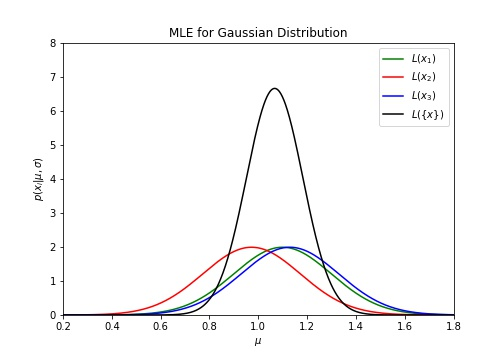

Now we can just read off the maximum likelihood solution.  Use `np.argsort()` to figure out the argument of the largest value and print that index of `xgrid`.

In [ ]:
indices = ____.____(____)
index_max = ____[____]
print("Likelihood is maximized at %.3f" % ____[____])

## Quantifying Estimated Uncertainty (Ivezic 4.2.5)  <a class="anchor" id="four"></a>

Our ML estimate of $\mu$ is not perfect. The uncertaintly of the estimate is captured by the likelihood function, but we'd like to quantify it with a few numbers.

We *define* the uncertainty on our MLEs as second (partial) derivatives of log-likelihood:

$$\sigma_{jk} = \left( - \frac{d^2}{d\theta_j} \frac{\ln L}{d\theta_k} \Biggr\rvert_{\theta=\theta_0}\right)^{-1/2}.$$

The marginal error bars for each parameter, $\theta_i$ are given by the diagonal elements, $\sigma_{ii}$, of this **covariance matrix**.

In our example, the uncertainly on the mean is 
$$\sigma_{\mu} = \left( - \frac{d^2\ln L(\mu)}{d\mu^2}\Biggr\rvert_{\mu_0}\right)^{-1/2}$$

We find
$$\frac{d^2\ln L(\mu)}{d\mu^2}\Biggr\rvert_{\mu_0} = - \sum_{i=1}^N\frac{1}{\sigma^2} = -\frac{N}{\sigma^2},$$
since, again, $\sigma = {\rm constant}$.  

Then $$\sigma_{\mu} = \frac{\sigma}{\sqrt{N}}.$$

So, our estimator of $\mu$ is $\overline{x}\pm\frac{\sigma}{\sqrt{N}}$, which is the result that we are already familiar with.

The result for $\sigma_{\mu}$ has been derived by expanding $\ln L$ in a Taylor series and retaining terms up to second order (essentially, $\ln L$ is approximated by a parabola, or an ellipsoidal surface in multidimensional cases, around its maximum). If this expansion is exact (as is the case for a Gaussian error distribution), then we've completely captured the error information.

In general, this is not the case and the likelihood surface can significantly deviate from a smooth elliptical surface. Furthermore, it often happens in practice that the likelihood surface is multimodal. It is always a good idea to visualize the likelihood surface when in doubt (see examples in §5.6 in the textbook).

## Confidence Intervals <a class="anchor" id="five"></a>

The $(\mu_0 - \sigma_\mu, \mu_0 + \sigma_\mu)$ range gives us a **confidence interval**.

In frequentist interptetation, if we repeated the same measurement a hundred times, we'd find that 68 experiments yield a result within the computed confidence interval ($1 \sigma$ errors).

### Confidence Estimates: Bootstrap and Jackknife (Ivezic 4.5)

We often assume that the distribution is Gaussian and our samples are large, but even if that is not the case, we can still compute good confidence intervals (e.g., $a<x<b$ with 95\% confidence) using **resampling** strategies.

Remember that we have a data set $\{x_i\}$ from which we have estimated the distribution as $f(x)$ for a true distribution $h(x)$.  

In **bootstrapping** we map the uncertainty of the parameters by re-sampling from our distribution (with replacement) $B$ times, such that we obtain $B$ measures of our parameters.   So, if we have $i=1,\dots,N$ data points in $\{x_i\}$, we draw $N$ of them to make a new sample, where some values of $\{x_i\}$ will be used more than once.

The **jackknife** method is similar except that we don't use a sample size of $N$, rather we leave off one or more of the observations from $\{x_i\}$.  As with bootstrap, we do this multiple times, generating samples from which we can determine our uncertainties.

### When to bootstrap or jackknife?

- Jackknife estimates are usually easier to calculate, easier to apply for complex sampling schemes, and automtically remove bias.
- Bootstrap is better for computing confidence intervals because it maps out the full distribution of the statistic instead of assuming asymptotic normality.
- Bootstrap is random resampling so gives different results each time. Whereas jackknifing gives repeatable results.

It is generally a good idea to use both methods and compare the results. Use either/both with caution with $N$ is small!

An example of bootstrap is given below, using [astroML.resample.bootstrap](http://www.astroml.org/modules/generated/astroML.resample.bootstrap.html), where the arguments are 1) the data, 2) the number of bootstrap resamples to use, and 3) the statistic to be computed.

You'll get some more practice with this in a homework assignment based on Data Camp.

In [ ]:
# Ivezic v2, Figure 4.3, modified slightly by GTR
# %load ../code/fig_bootstrap_gaussian.py
"""
Bootstrap Calculations of Error on Mean
---------------------------------------
Figure 4.3.

The bootstrap uncertainty estimates for the sample standard deviation
:math:`\sigma` (dashed line; see eq. 3.32) and :math:`\sigma_G` (solid line;
see eq. 3.36). The sample consists of N = 1000 values drawn from a Gaussian
distribution with :math:`\mu = 0` and :math:`\sigma = 1`. The bootstrap
estimates are based on 10,000 samples. The thin lines show Gaussians with
the widths determined as :math:`s / \sqrt{2(N - 1)}` (eq. 3.35) for
:math:`\sigma` and :math:`1.06 s / \sqrt{N}` (eq. 3.37) for :math:`\sigma_G`.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt

from astroML.resample import bootstrap
from astroML.stats import sigmaG

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
#if "setup_text_plots" not in globals():
#    from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=12, usetex=True)

m = 1000  # number of points
n = 10000  # number of bootstraps

#------------------------------------------------------------
# sample values from a normal distribution
np.random.seed(123)
data = norm(0, 1).rvs(m)

#------------------------------------------------------------
# Compute bootstrap resamplings of data
mu1_bootstrap = bootstrap(data, n, np.std, kwargs=dict(axis=1, ddof=1))
mu2_bootstrap = bootstrap(data, n, sigmaG, kwargs=dict(axis=1))

#------------------------------------------------------------
# Compute the theoretical expectations for the two distributions
xgrid = np.linspace(0.8, 1.2, 1000)

sigma1 = 1. / np.sqrt(2 * (m - 1))
pdf1 = norm(1, sigma1).pdf(xgrid)

sigma2 = 1.06 / np.sqrt(m)
pdf2 = norm(1, sigma2).pdf(xgrid)

#------------------------------------------------------------
# Plot the results
fig, ax = plt.subplots(figsize=(8, 8))

ax.hist(mu1_bootstrap, bins=50, density=True, histtype='step',
        color='blue', ls='dashed', label=r'$\sigma\ {\rm (std. dev.)}$')
ax.plot(xgrid, pdf1, color='gray')

ax.hist(mu2_bootstrap, bins=50, density=True, histtype='step',
        color='red', label=r'$\sigma_G\ {\rm (quartile)}$')
ax.plot(xgrid, pdf2, color='gray')

ax.set_xlim(0.82, 1.18)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$p(\sigma|x,I)$')

ax.legend()

plt.show()

From Ivezic: "The bootstrap uncertainty estimates for the sample standard deviation $\sigma$ (dashed line; see Eq. 3.32) and $\sigma_G$ (solid line; see Eq. 3.36). The sample consists of N = 1000 values drawn from a Gaussian distribution with $\mu = 0$ and $\sigma = 1$. The bootstrap estimates are based on 10,000 samples. The thin grey lines show Gaussians with the widths determined as $s / \sqrt{2(N - 1)}$ (Eq. 3.35) for $\sigma$ and $1.06 s / \sqrt{N}$ (Eq. 3.37) for $\sigma_G$."

## MLE applied to a Heteroscedastic Gaussian (Ivezic 4.2.6) <a class="anchor" id="six"></a>

Now let's look at a case where the errors are heteroscedastic.  For example if we are measuring the length of a [rod](https://www.nist.gov/image/meter27jpg) and have $N$ measurements, $\{x_i\}$, where the error for each measurement, $\sigma_i$ is known.  Since $\sigma$ is **not** a constant, then following the above, we have

$$\ln L = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma_i^2}.$$

Taking the derivative:
$$\frac{d\;{\rm lnL}(\mu)}{d\mu}\Biggr\rvert_{\hat \mu} = \sum_{i=1}^N \frac{(x_i - \hat \mu)}{\sigma_i^2} = 0,$$
then simplifying:

$$\sum_{i=1}^N \frac{x_i}{\sigma_i^2} = \sum_{i=1}^N \frac{\hat \mu}{\sigma_i^2},$$

yields a MLE solution of 
$$\hat \mu = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$

which is just a variance-weighted mean, with uncertainty
$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}.$$




GTR: Skipped this in 2022

## Aside: Cost Functions <a class="anchor" id="seven"></a>

Recall from Lecture 3 that we measured the deviation from expected in three different ways
$$d_i = x_i - \mu,$$  
$$|x_i-\mu|,$$
and
$$(x_i-\mu)^2.$$

When trying to determine the best model parameters, we have to specify a "cost function", which is basically the prescription for evaluating the difference (distance) between our estimator and the true value.  This is otherwise known as the "norm", or the total length of the distances.  The first form above represents the $L_0$ norm, while the next two are the $L_1$ norm (the "taxi-cab" norm) and the $L_2$ norm (the "as the crow flies" norm).  

So far we have been using an $L_2$ norm (which comes about simply from the definition of a Gaussian with the $(x_i-\mu)^2$ term).  Later in the course we will encounter machine learning algorithms that allow us to specify different norms (different cost functions).

The [$L_p$ norm](https://www.wikiwand.com/en/Lp_space) can be defined as $\sum_{i=1}^N (y_i -M(x_i))^p/\sigma^p$.

See [this Medium article](https://medium.com/@montjoile/l0-norm-l1-norm-l2-norm-l-infinity-norm-7a7d18a4f40c) and Ivezic, 4.2.8.

### Truncated/Censored Data

Note that knowing how to deal with missing data points ("censored data") is often quite important, but adds complications that we don't have time to get into here.  For more, see Ivezic 4.2.7.

## "Goodness" of Fit (Ivezic 4.3)  <a class="anchor" id="eight"></a>

The MLE approach tells us what the "best" model parameters are, but not how good the fit actually is.  If the model is wrong, "best" might not be particularly revealing ("Garbage In = Garbage Out")!  For example, if you have $N$ points drawn from a linear distribution, you can always fit the data perfectly with an $N-1$ order polynomial.  But that won't help you predict future measurements.

We can describe the **goodness of fit** as 
> whether or not it is likely to have obtained $\ln L_0$ by randomly drawing from the data.  That means that we need to know the *distribution* of $\ln L$ and not just the maximum.  

For the Gaussian case we have just described, we do a standard transform of variables and compute the so-called $z$ score for each data point (basically the number of standard deviations away from the mean that this point is), writing 
$$z_i = (x_i-\mu)/\sigma,$$ then
$$\ln L = {\rm constant} - \frac{1}{2}\sum_{i=1}^N z^2 = {\rm constant} - \frac{1}{2}\chi^2.$$

Here, $\chi^2$ is the thing whose distribution we discussed last week.

So for Gaussian uncertainties, $\ln L$ is distributed as $\chi^2$.  

The mean of the $\chi^2$ distribution is $N-k$ and its standard deviation is $\sqrt{2(N-k)}$.

Let's visualize that.

In [ ]:
# Execute this cell to make the plot
# %load ../code/fig_chi2_distribution.py
"""
Example of a chi-squared distribution
---------------------------------------
Figure 3.14.

This shows an example of a :math:`\chi^2` distribution with various parameters.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from scipy.stats import chi2
from matplotlib import pyplot as plt

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
#from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=12, usetex=True)

#------------------------------------------------------------
# Define the distribution parameters to be plotted
k_values = [1, 2, 5, 7]
linestyles = ['-', '--', ':', '-.']
mu = 0
xplot = np.linspace(-1, 10, 1000)

#------------------------------------------------------------
# plot the distributions
fig, ax = plt.subplots(figsize=(5, 3.75))
fig.subplots_adjust(bottom=0.12)

for k, ls in zip(k_values, linestyles):
    dist = chi2(k, mu)
    idx = np.argsort(dist.pdf(xplot))[-1]
    #print(f"The peak Q value for {k} degrees of freedom is {xplot[idx]}.")
    print("The peak Q value for {0:d} degrees of freedom is {1:3.2f}.".format(k,xplot[idx]))
                                                                                       
    plt.plot(xplot, dist.pdf(xplot), ls=ls, c='black',
             label=r'$k=%i$' % k)

plt.xlim(0, 10)
plt.ylim(0, 0.5)

plt.xlabel('$Q$')
plt.ylabel(r'$p(Q|k)$')
plt.title(r'$\chi^2\ \mathrm{Distribution}$')

plt.legend()
plt.show()

We define the $\chi^2$ per degree of freedom, $\chi^2_{dof}$, as
$$\chi^2_{dof} = \frac{1}{N-k}\sum_{i=1}^N z^2_i.$$

For a good fit, we would expect that $\chi^2_{dof}\approx 1$.  If $\chi^2_{dof}$ is significantly larger than 1, then it is likely that we are not using the correct model.

We can also get overly high or low values of $\chi^2_{dof}$ if our errors are under- or over-estimated as shown below:

![Ivezic, Figure 4.1](http://www.astroml.org/_images/fig_chi2_eval_1.png)

### Example: Polynomial Fitting  <a class="anchor" id="nine"></a>

Let's use the example from http://jakevdp.github.io/blog/2015/08/07/frequentism-and-bayesianism-5-model-selection/
to illustrate some ideas about goodness of fit and model selection.

In [ ]:
#Execute this cell to load all of the modules we'll need and define the data array.
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize

# generate (x,y, sigma_y) "data" 
data = np.array([[ 0.42,  0.72,  0.  ,  0.3 ,  0.15,
                   0.09,  0.19,  0.35,  0.4 ,  0.54,
                   0.42,  0.69,  0.2 ,  0.88,  0.03,
                   0.67,  0.42,  0.56,  0.14,  0.2  ],
                 [ 0.33,  0.41, -0.25,  0.01, -0.05,
                  -0.05, -0.12,  0.26,  0.29,  0.39, 
                   0.31,  0.42, -0.01,  0.58, -0.2 ,
                   0.52,  0.15,  0.32, -0.13, -0.09 ],
                 [ 0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1  ]])

In [ ]:
#Functions to do a polynomial fit, compute the likelihood, and determine the best-fit parameters.
#Nothing for you to do, just run.  (But see if you can follow what is going on.)
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(stats.norm.logpdf(*args) for args in zip(y, y_fit, sigma_y))

# a direct optimization approach is used to get best model 
# parameters (which minimize -logL)
def best_theta(degree, model=polynomial_fit, data=data):
    theta_0 = (degree + 1) * [0]
    neg_logL = lambda theta: -logL(theta, data, model)
    return optimize.fmin_bfgs(neg_logL, theta_0, disp=False)

In [ ]:
#Execute this cell.  See if you understand what it is doing.
x, y, sigma_y = data
Ndata = x.size

# get best-fit parameters for linear, quadratic and cubic models
theta1 = best_theta(1, data=data)
theta2 = best_theta(2, data=data)
theta3 = best_theta(3, data=data)
# generate best fit lines on a fine grid 
xgrid = np.linspace(-0.1, 1.1, 1000)
yfit1 = polynomial_fit(theta1, xgrid)
yfit2 = polynomial_fit(theta2, xgrid)
yfit3 = polynomial_fit(theta3, xgrid)

# plot 
fig, ax = plt.subplots(figsize=(16, 8))
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
ax.plot(xgrid, yfit1, label='best linear model')
ax.plot(xgrid, yfit2, label='best quadratic model')
ax.plot(xgrid, yfit3, label='best cubic model')
ax.legend(loc='best', fontsize=14)
ax.set(xlabel='x', ylabel='y', title='data');

In [ ]:
#Exit Ticket Question: 
#Can you write down the equation for the cubic fit?

print(theta1,theta2,theta3)

We can use $\chi^2$ per degree of freedom to determine which fit is "best".  It is computed as 
$$ \chi^2_{dof}  = \frac{1}{N-k} \sum_i^N \left( \frac{y - y_{fit}}{\sigma_y} \right)^2, $$
where $N$ is the number of data points and $k$ is the number of free model parameters (here 2, 3, and 4).

For large values of $(N-k)$ (larger than about 10), the distribution of 
$\chi^2$ per degre of freedom is approximately Gaussian with a width of
$\sigma=\sqrt{2/(N-k)}$. 

In [ ]:
#Complete and execute this cell to compute chi2: sum{[(y-yfit)/sigma_y]^2} 
chi21 = np.sum(((y-polynomial_fit(theta1, x))/sigma_y)**2) 
chi22 = np.sum(((y-polynomial_fit(____, x))/sigma_y)**2) 
chi23 = np.sum(((y-polynomial_fit(____, x))/sigma_y)**2) 
# normalize by the number of degrees of freedom
# the number of fitted parameters is 2, 3, 4
chi2dof1 = chi21/(Ndata - 2)
chi2dof2 = chi22/(____)
chi2dof3 = chi23/(____)

print("CHI2:")
print('   best linear model:', chi21)
print('best quadratic model:', chi22)
print('    best cubic model:', chi23)
print("CHI2 per degree of freedom:")
print('   best linear model:', chi2dof1)
print('best quadratic model:', chi2dof2)
print('    best cubic model:', chi2dof3)

Obviously, the cubic model has the lowest $\chi^2$ ("fits the best"), but 
it has 4 free parameters while the linear model has only 2 free parameters.

### Model Comparison  <a class="anchor" id="twelve"></a>

**Which model should we adopt?**

We need a modified approach whenever the models we're comparing have different numbers of parameters. Such an approach should account for **model complexity** and effectively penalize models with additional parameters that are not constrained by the data. This is often called an ***Occam penalty***, because we're trying to incorporate [Occam's Razor](https://www.wikiwand.com/en/Occam%27s_razor#:~:text=Occam's%20razor%2C%20Ockham's%20razor%2C%20Ocham's,is%20usually%20the%20right%20one.).

> *All else being equal (i.e., each model fits the data equally well), the less complex model is favored.*

We can always increase the number of paramters in our model and improve the fit.  So we need some kind of "scoring" system that accounts for the complexity of the model.

A common scoring system is the **Aikake information criterion (AIC)**.  For $N$ data points and a model with $k$ parameters,
$${\rm AIC} \equiv -2 \ln (L_0(M)) + 2k + \frac{2k(k+1)}{N-k-1},$$
where the 2nd and 3rd terms are designed to penalize complex models relative to simple ones.

Another scoring system is the **Bayesian information criterion (BIC)**, which is computed as
$${\rm BIC} \equiv -2 \ln (L_0(M)) + k \ln N.$$ 
We'll see this again next time.

Let's use BIC to choose the best polynomial from the polynomial fitting example. 
Starting with

$${\rm BIC} = \chi^2 + k \ln N,$$ 

with $N=20$ we have:

<pre>
     model     chi2    k   k*ln(N)   BIC   
     ------------------------------------
    linear    11.50    2    5.99    17.49   
  quadratic    9.29    3    8.99    18.28  
     cubic     8.98    4   11.98    20.96 
</pre>

Therefore, the improvement in $\chi^2$ for the quadratic model (nevermind the cubic model), relative to the linear model, is not large enough to justify another free model parameter.

Fill in the blanks of the next cell to get some practice.

In [ ]:
#Complete and execute this cell
L = [] #Array with all of the likelihood values
A = [] #Array with all of the AIC values
B = [] #Array with all of the  BICvalues
neg_LogL1 = -logL(theta1, data)+10  #+10 for plotting purposes
neg_LogL2 = -logL(theta2, data)+10
neg_LogL3 = -logL(theta3, data)+10
L = np.append(L,neg_LogL1)
L = np.append(L,neg_LogL2)
L = np.append(L,neg_LogL3)

xplot = np.arange(len(L))+1 #x values for plotting.

AIC1 = 2.*neg_LogL1 + 2.*len(theta1) + 2.*len(theta1)*(len(theta1)+1)/(len(data[0])-len(theta1)-1)
AIC2 = ____ #Complete
AIC3 = ____ #Complete
A = np.append(A,AIC1)
A = np.append(A,AIC2)
A = np.append(A,AIC3)
BIC1 = 2.*neg_LogL1 + len(theta1)*np.log(len(data[0]))
BIC2 = ____ #Complete
BIC3 = ____ #Complete
B = np.append(B,BIC1)
B = np.append(B,BIC2)
B = np.append(B,BIC3)

print("-logL:", L)
print("AIC:", A)
print("BIC:", B)


fig = plt.subplots(figsize=(16, 8))
plt.plot(xplot, L, label='Likelihood+10')
plt.plot(xplot, A, label='AIC')
plt.plot(xplot, B, label='BIC')
plt.legend()
plt.xlabel("k")
plt.ylabel("Score")
print(L)
print(B)
print(A)

We'll do more with this later (and for homework), but for now we'll leave off with an example showing an attempt to fit a complex 1-D distribution with multiple Gaussians (from Ivezic Figure 4.2). $\chi^2$ would keep falling with more components, but using the AIC or BIC we find that 3 Gaussians provides the best fit.

![Ivezic, Fkigure 4.2](http://www.astroml.org/_images/fig_GMM_1D_1.png)

## Hypothesis Testing <a class="anchor" id="eleven"></a>

A common problem in statistics is **hypothesis testing**, i.e., testing whether an observation or observations agree with a certain hypothesis. 

The simplest example is whether a measured value $x_i$ or an entire dataset $\{x_i\}$ are consistent with having been drawn from a Gaussian distribution, $\mathcal{N}(\mu,\sigma)$. In this example, $\mathcal{N}(\mu,\sigma)$ is the ***null hypothesis***, and we are trying to reject it in order to claim that we have measured some effect. 

A great example in astronomy is ***source detection*** in images that suffer from a substantial noise background (e.g., atmospheric fluctuations in optical images).

In the image below (from the [photutils](https://photutils.readthedocs.io/en/stable/background.html) package) we have sources embedded in Gaussian image noise. 

- Here the null hypothesis is that the flux in each pixel is caused by background fluctuations, and if we can reject it then we can achieve source detection. 
- Ideally we would like to be able to find the real sources in here and assign a number that says how much they reject the null background hypothesis. 
- We would establish a threshold in these numbers above which we could accept sources, knowing that we might be falsely rejecting some real ones, but hopefully not accepting too many spurious noise sources.

![https://photutils.readthedocs.io/en/stable//background-1.svg](https://photutils.readthedocs.io/en/stable//background-1.svg)

Imagine we have data $\{x_i\}$, for example pixel brightness in image data. Under an assumption about the null background distribution, $h_0(x)$, we can compute the probability that a data point would have a value as large or greater than that observed. This is called the ***$p$-value*** of the data:

$$ p_i = \int_{x_i}^\infty h_0(x)dx \equiv 1 - \int_{-\infty}^{x_i} h_0(x)dx = 1-H_0(x_i),$$

where $H_0(x)$ is the CDF (cumulative density function) of the null distribution.

In the image below, we show the distribution of a statistic $S$ under a null hypothesis $\mathcal{H}_\mathrm{null}$. The $p$-value of the observed statistic $S_\mathrm{obs}$ is shown graphically.

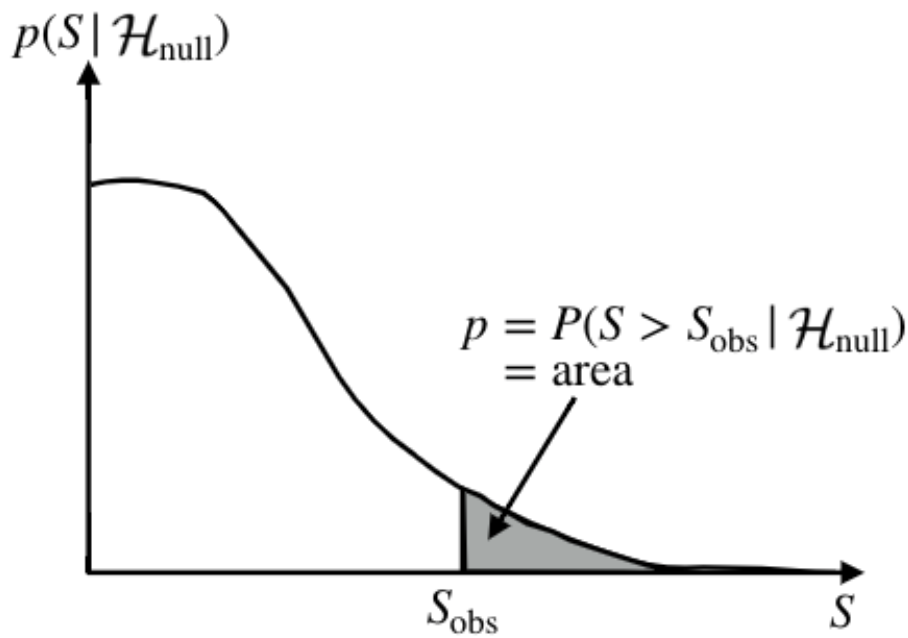

Typically, a threshold $p$-value is adopted, called the **significance, $\alpha$**. In a classification scheme, data would then reject the null hypothesis if $p_i\leq\alpha$. If $\alpha=0.05$, such data would reject the null hypothesis at the $0.05$ significance level. 

**NOTE**
- If we can't reject the null hypothesis then it doesn't mean the data belongs to the background. It could be that our sample is simply not large enough to detect an effect. 
- Rejecting the null hypothesis does not necessarily mean that we've proven a signal hypothesis. Our model of the null hypothesis could be bad, or there could be many other things we have not considered.
- There is ***alot*** of mis-use and abuse of p-values in the scientific literature. Take a quick scan of [this](https://fivethirtyeight.com/features/statisticians-found-one-thing-they-can-agree-on-its-time-to-stop-misusing-p-values/) and [this](https://www.wikiwand.com/en/Misuse_of_p-values) during class, and read thoroughly in your own time. 